<a href="https://colab.research.google.com/github/mesuat/social_network_analysis_fraud_detection/blob/master/GT_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Data & Libraries**



In [1]:
!gdown --id 11XnkXEThDMjDaCfUa3tkuGqu_XhgPEuo

Downloading...
From: https://drive.google.com/uc?id=11XnkXEThDMjDaCfUa3tkuGqu_XhgPEuo
To: /content/AA_UseCase_Data.zip
82.4MB [00:00, 114MB/s] 


In [2]:
!unzip AA_UseCase_Data.zip

Archive:  AA_UseCase_Data.zip
  inflating: train.csv               


In [3]:
import os 

import pandas as pd
import numpy as np
import itertools

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.metrics import average_precision_score, confusion_matrix, roc_auc_score, make_scorer, plot_precision_recall_curve, plot_roc_curve, average_precision_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import lightgbm as lgb
import xgboost as xgb
import pickle
import os
import gc
gc.enable()

from imblearn.under_sampling import RandomUnderSampler

import time
import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
#loading data
print("Loading data..")
start = time.time()
data = pd.read_csv("train.csv", index_col="Id")
end = time.time()
print("Loading finished. It took {0:.2f} seconds.".format(end-start))

Loading data..


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Loading finished. It took 3.90 seconds.


In [5]:
df = data.copy()

In [6]:
df.tail(2)

,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
Id,,,,,,,,,,,
3352884,718,PAYMENT,11726.71,C8642260114,2980280.08,2968553.37,C5055233979,94282.56,106009.27,0,0
3352886,718,CASH_IN,115158.72,C0725945548,3599990.89,3715149.61,C1039537388,216298.60,216298.60,0,0


Exploratory Data Analysis

In [7]:
print("Data has {} number of rows and {} number of columns.".format('{:,}'.format(df.shape[0]), df.shape[1]))
print("\nThe names of columns are {}.".format(list(df.columns)))

Data has 2,372,805 number of rows and 11 number of columns.

The names of columns are ['step', 'action', 'amount', 'nameOrig', 'oldBalanceOrig', 'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest', 'isFraud', 'isFlaggedFraud'].


In [8]:
print(df.describe(include="all"))

                step   action        amount     nameOrig  oldBalanceOrig  newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest       isFraud  isFlaggedFraud
count   2.372805e+06  2372805  2.372805e+06      2372805    2.372805e+06    2.372805e+06      2372805    2.372805e+06    2.372805e+06  2.372805e+06       2372805.0
unique           NaN        5           NaN        14141             NaN             NaN        54904             NaN             NaN           NaN             NaN
top              NaN  CASH_IN           NaN  C4448860867             NaN             NaN  B9550196511             NaN             NaN           NaN             NaN
freq             NaN  1032064           NaN       106148             NaN             NaN        60828             NaN             NaN           NaN             NaN
mean    1.832920e+02      NaN  1.454519e+05          NaN    3.332226e+06    3.315864e+06          NaN    2.823591e+05    3.299378e+05  7.501670e-05             0.0
std     1.258774

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372805 entries, 0 to 3352886
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   action          object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 217.2+ MB


In [10]:
if df.isnull().values.any() == False: print("There is not any missing value in the data.")

There is not any missing value in the data.


There are 178 number of fraudulent and 2,372,627 number of non fraudulent transactions. 
Fraudulent transactions makes up 0.008% percent of total data.



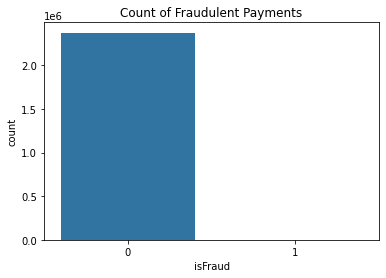

Number of normal examples:  2372627
Number of fradulent examples:  178


In [11]:
print("There are {} number of fraudulent and {:,} number of non fraudulent transactions. \nFraudulent transactions makes up {:.3%} percent of total data.\n"
.format(df.isFraud.value_counts()[1], df.isFraud.value_counts()[0], df.isFraud.value_counts()[1] / df.shape[0]))

dfNotFraud = df.loc[df.isFraud == 0]
dfFraud = df.loc[df.isFraud == 1]

sns.countplot(x="isFraud",data=df)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",dfNotFraud.isFraud.count())
print("Number of fradulent examples: ",dfFraud.isFraud.count())

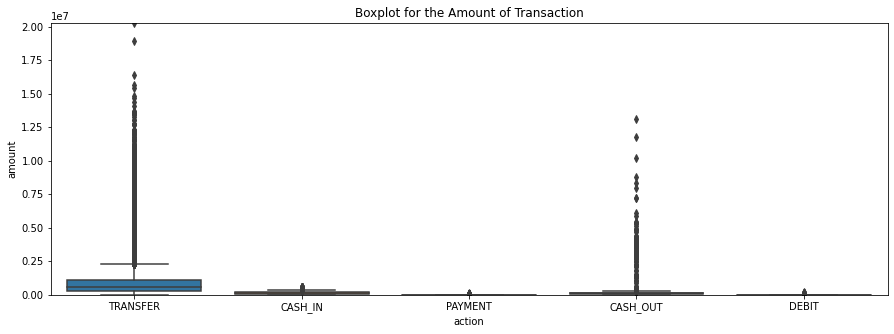

In [12]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(15,5))
sns.boxplot(x=df.action,y=df.amount)
plt.title("Boxplot for the Amount of Transaction")
plt.ylim(0,df.amount.max())
plt.show;

In [13]:
print("Maximum amount in fraudulent transactions is {:,}.".format(dfFraud.amount.max()))

Maximum amount in fraudulent transactions is 13,123,020.49.


In [14]:
df.loc[df.amount == dfFraud.amount.max()]

,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
Id,,,,,,,,,,,
3292950,492,CASH_OUT,13123020.49,C2700558096,13123020.49,0.0,C6450083574,246191.3,246191.3,1,0


CASH_IN     1032064
CASH_OUT     560152
PAYMENT      553096
TRANSFER     139371
DEBIT         88122
Name: action, dtype: int64


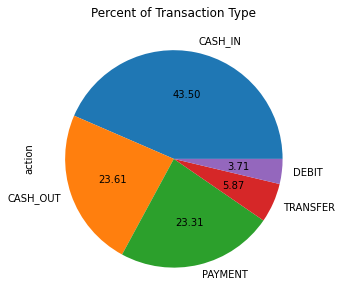

In [15]:
print(df.action.value_counts())

df.action.value_counts().plot(kind='pie', 
                              title="Percent of Transaction Type", 
                              autopct="%.2f",
                              figsize=(5,5)
                              )
plt.show();

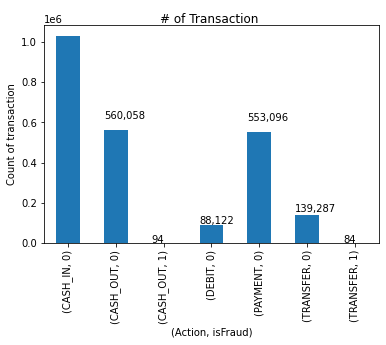

In [16]:
ax = df.groupby(['action', 'isFraud']).size().plot(kind='bar')

ax.set_title("# of Transaction ", loc="center", pad=2)
ax.set_xlabel("(Action, isFraud)")
ax.set_ylabel("Count of transaction")

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.1))

In [17]:
'''
Fraudulent transactions are those related to money outflows ('Cash Out' & 'Transfer').
'''
dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.action == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.action == 'CASH_OUT')]

print ('The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) 

print ('\nThe number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) 

The number of fraudulent TRANSFERs = 84

The number of fraudulent CASH_OUTs = 94


In [18]:
'''
It turns out that the origin of 'isFlaggedFraud' is unclear. None of the entries is different than zero. 
'''
if df.isFlaggedFraud.unique() == 0: print("The values of 'isFlaggedFraud' column has only value of zero and can be dropped.")

dfTransfer = df.loc[df.action == 'TRANSFER']

print('\nMinimum amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.min())) 

print('\nMaximum amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) 

The values of 'isFlaggedFraud' column has only value of zero and can be dropped.

Minimum amount transacted in a TRANSFER where isFlaggedFraud is not set= 10.0

Maximum amount transacted in a TRANSFER where isFlaggedFraud is not set= 20268571.11


In [19]:
print("This is important!\nWithin fraudulent transactions, there are {} number of destinations for TRANSFERS that are also originators for CASH_OUTs and of those {} are unique.".
      format(len(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)), len(dfFraudTransfer[dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)].nameDest.drop_duplicates())))

This is important!
Within fraudulent transactions, there are 84 number of destinations for TRANSFERS that are also originators for CASH_OUTs and of those 61 are unique.


In [27]:
print("Within fraudulent transactions, there are {} number of fraudulent CASH_OUTs, whose origin does not belong to fraudulent TRANSFERs.".
      format(dfFraudCashout[~dfFraudCashout.nameOrig.isin(dfFraudTransfer.nameDest)].shape[0]))

Within fraudulent transactions, there are 32 number of fraudulent CASH_OUTs, whose origin does not belong to fraudulent TRANSFERs.


In [20]:
if dfFraudTransfer.nameDest.isin(dfNotFraud.nameOrig).any() == False : print("There is not any fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs.")

There is not any fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs.


In [ ]:
df = df.loc[(df.action == 'TRANSFER') | (df.action == 'CASH_OUT')]

randomState = 42
np.random.seed(randomState)

# Eliminate columns shown to be irrelevant for analysis in the EDA
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
df.loc[df.action == 'TRANSFER', 'action'] = 0
df.loc[df.action == 'CASH_OUT', 'action'] = 1
df.action = df.action.astype(int) # convert dtype('O') to dtype(int)

df.shape

(699523, 8)

In [ ]:
df['DiffBalanceOrig'] = df.newBalanceOrig + df.amount - df.oldBalanceOrig
df['DiffBalanceDest'] = df.oldBalanceDest + df.amount - df.newBalanceDest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isFraud'], df['isFraud'], test_size = 0.2,
                                                    stratify = df['isFraud'],
                                                    shuffle = True,
                                                    random_state = 42)

In [ ]:
df_train = pd.concat([X_train, y_train], axis = 1)

Stratified K-Fold

In [ ]:
def folds(data, target = "isFraud", n_splits = 5):
  data["kfold"] = -1
  np.random.seed(42)
  data = data.sample(frac=1).reset_index(drop=True)
  
  y = data[target].values
  
  kf = StratifiedKFold(n_splits=n_splits)
  
  for f, (t_, v_) in enumerate(kf.split(X=data, y=y)):
    data.loc[v_, 'kfold'] = f
  
  return data

In [ ]:
df_train = folds(df_train, "isFraud", 5)

In [ ]:
df_train.head(2)

,step,action,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,DiffBalanceOrig,DiffBalanceDest,isFraud,kfold
0,331,1,57397.90,8481053.46,8423655.56,83137.17,83137.17,0.0,57397.90,0,0
1,119,1,131705.76,2929756.76,2798051.00,42749.95,42749.95,0.0,131705.76,0,0


In [ ]:
df_train.groupby(by = ["isFraud", "kfold"]).step.count()

isFraud  kfold
0        0        111896
         1        111895
         2        111895
         3        111895
         4        111895
1        0            28
         1            29
         2            29
         3            28
         4            28
Name: step, dtype: int64

In [ ]:
y_test.value_counts()

0    139869
1        36
Name: isFraud, dtype: int64

**Parameter Tuning**

In [ ]:
features = [f for f in df_train.columns if f not in ("isFraud", "kfold")]

train_grid = df_train[df_train.kfold == 0].reset_index(drop=True)
X_train_grid = train_grid[features].values
y_train_grid = train_grid.isFraud.values

X_train_grid.shape

(111924, 9)

In [ ]:
parameters = {
    "learning_rate"    : [0.05, 0.10] ,
    "max_depth"        : [ 3, 4, 5, 6],
    "min_child_weight" : [ 1, 2, 3 ],
    "n_estimators" : [80, 100, 120]
    }

weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())

gsearch = GridSearchCV(XGBClassifier(n_jobs=-1, nthread=4, seed=42, scale_pos_weight=weights),
                   param_grid = parameters, 
                   scoring='roc_auc',
                   return_train_score = True,
                   cv=5)

gsearch.fit(X_train_grid, y_train_grid)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=3939.9718309859154,
                                     seed=42, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [3, 4, 5, 6],
                    

In [ ]:
gsearch.best_params_, gsearch.best_score_

({'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 3,
  'n_estimators': 100},
 0.9926283075050291)

Validation Data Prediction Performance

In [ ]:
def kfold_predict(fold):

  weights = (df_train.isFraud == 0).sum() / (1.0 * (df_train.isFraud == 1).sum())

  features = [
              f for f in df_train.columns if f not in ("isFraud", "kfold")
              ]
  
  train = df_train[df_train.kfold != fold].reset_index(drop=True)
  valid = df_train[df_train.kfold == fold].reset_index(drop=True)

  x_train_fold = train[features].values
  x_valid_fold = valid[features].values

  model = XGBClassifier(n_jobs=-1,
                        learning_rate = 0.1,
                        max_depth = 5,
                        min_child_weight = 3,
                        n_estimators = 100,
                        scale_pos_weight = weights
                        )

  model.fit(x_train_fold, train.isFraud.values)
  valid_preds = model.predict_proba(x_valid_fold)[:, 1]

  roc_auc = roc_auc_score(valid.isFraud.values, valid_preds)

  print(f"Fold = {fold}, AUC = {roc_auc}")

In [ ]:
if __name__ == "__main__":
  for fold_ in range(5):
    kfold_predict(fold_)

Fold = 0, AUC = 0.9763058043693633
Fold = 1, AUC = 0.9995375898895362
Fold = 2, AUC = 0.9971377106924441
Fold = 3, AUC = 0.9998665841062732
Fold = 4, AUC = 0.9976028227994356


In [ ]:
weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())

clf = XGBClassifier(n_jobs=-1,
                    learning_rate = 0.1,
                    max_depth = 5,
                    min_child_weight = 3,
                    n_estimators = 100,
                    scale_pos_weight = weights
#                    booster = "dart"
                    )

y_pred = clf.fit(X_train, y_train).predict_proba(X_test)
print('AUC = {}'.format(roc_auc_score(y_test, y_pred[:, 1])))

AUC = 0.9999872896940868


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
      pass

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.9722222222222222
Precision metric in the testing dataset:  0.660377358490566




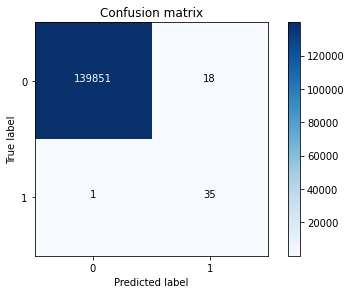

In [ ]:
y_pred = clf.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
print("Precision metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))
print("\n")

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

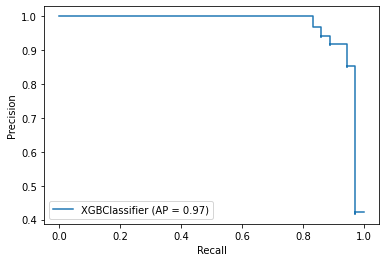

In [ ]:
plot_precision_recall_curve(clf, X_test, y_test)

plt.show;

**UnderSampling**

In [ ]:
undersample = RandomUnderSampler(random_state=42)
X_und, y_und = undersample.fit_resample(X_train, y_train)

clf_und = XGBClassifier(n_jobs=-1,
                    learning_rate = 0.1,
                    max_depth = 5,
                    min_child_weight = 3,
                    n_estimators = 100,
                    scale_pos_weight = weights
#                    booster = "dart"
                    )

y_pred_und = clf_und.fit(X_und, y_und).predict_proba(X_test.values)
print('AUC = {}'.format(roc_auc_score(y_test, y_pred_und[:, 1])))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


AUC = 0.9999426050248607


Better recall but much worse precision when undersampled. 

Recall metric in the testing dataset:  1.0
Precision metric in the testing dataset:  0.0012415077421802255




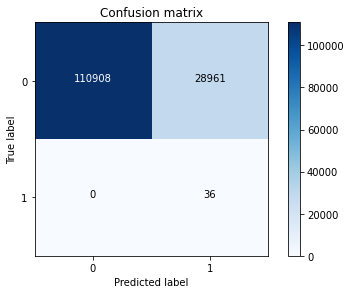

In [ ]:
print("Better recall but much worse precision when undersampled. \n")
    
y_pred_und = clf_und.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_und)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
print("Precision metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))
print("\n")

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

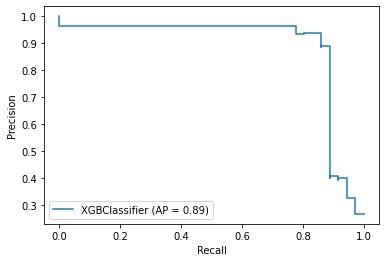

In [ ]:
plot_precision_recall_curve(clf_und, X_test.values, y_test)

plt.show;

In [ ]:
result = pd.concat([pd.DataFrame(y_test.values, index=(y_test.index), columns=["Actual"]), pd.DataFrame(y_pred, index=(y_test.index), columns=["Prediction"])], axis=1)

print("Transaction that was incorrectly evaluated as non fraudulent.\n")
data.loc[result.loc[(result["Actual"] == 1) & (result["Prediction"] == 0)].index]

Transaction that was incorrectly evaluated as non fraudulent.



,Id,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
483689,683944,40,TRANSFER,2589453.21,C9136552933,3239211.96,649758.75,C9533916276,0.0,2589453.21,1,0


In [ ]:
print("Transactions that were incorrectly evaluated as fraudulent.\n")
data.loc[result.loc[(result["Actual"] == 0) & (result["Prediction"] == 1)].index]

Transactions that were incorrectly evaluated as fraudulent.



,Id,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
1526871,2158138,235,TRANSFER,1443831.42,C1497338320,1426887.81,-16943.61,C7868705329,195801.59,1639633.02,0,0
980020,1386144,162,CASH_OUT,94984.13,C2848354838,1524681.55,1429697.41,C2460580973,34616.23,34616.23,0,0
1750194,2473974,262,TRANSFER,2153924.87,C3130225507,2323615.61,169690.74,C2104311250,726044.47,2879969.34,0,0
10397,14639,7,CASH_OUT,80.62,C6576391538,80.62,0.00,C5959097984,0.00,0.00,0,0
2105374,2975065,331,TRANSFER,1339976.62,C9570176344,3149104.02,1809127.41,C1255861000,105811.15,1445787.77,0,0
1874105,2648918,286,CASH_OUT,65449.51,C5115408259,932511.58,867062.07,C5003947781,166453.12,166453.12,0,0
2371583,3351123,715,CASH_OUT,64769.48,C1221614665,551052.15,486282.67,C2567280622,203826.49,203826.49,0,0
1373423,1941263,211,CASH_OUT,79635.76,C1814275757,1524690.51,1445054.75,C5206059650,91258.16,91258.16,0,0
1263686,1786817,190,TRANSFER,1642333.57,C9421167543,2145975.25,503641.68,C8894826651,230748.10,1873081.67,0,0
1517112,2144718,235,CASH_OUT,471216.75,C7147548297,3008948.39,2537731.64,C6737077150,103522.77,103522.77,0,0


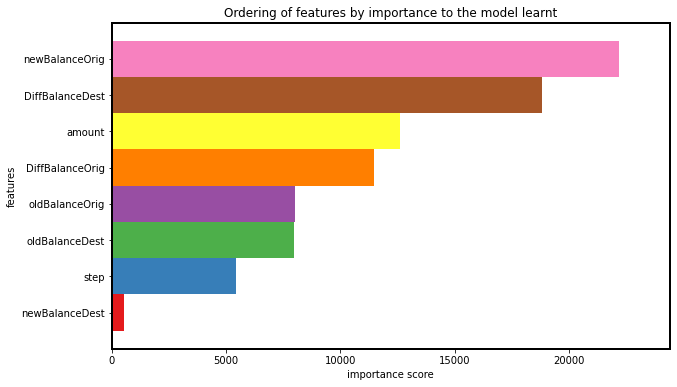

In [ ]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 10);
ax.set_ylabel('features', size = 10);
ax.set_yticklabels(ax.get_yticklabels(), size = 10);
ax.set_title('Ordering of features by importance to the model learnt', size = 12);

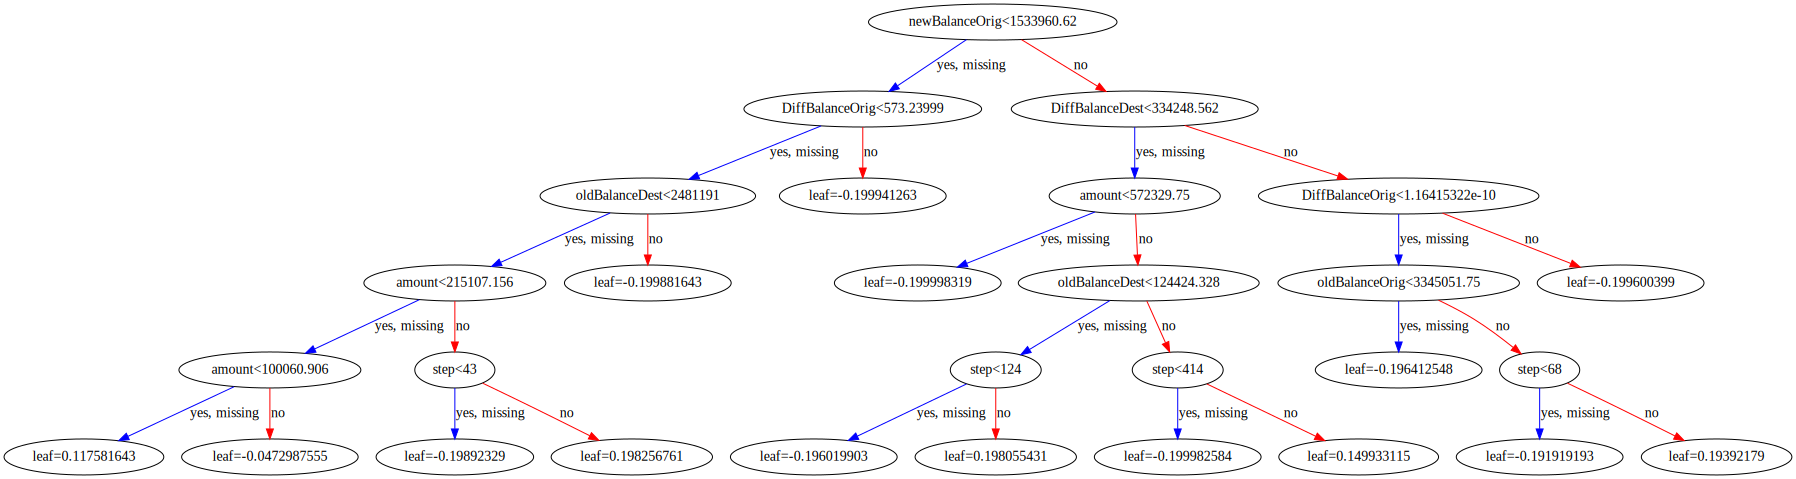

In [ ]:
to_graphviz(clf)